# Metaheuristics Exam
# João Luis Brasil Gondim

## Part 1: Discrete optimization - Traveling Salesperson Problem

<font size="3">I created a mixed model in which the <b>first generation of individuals of the Genetic Algorithm model is partly (80%) generated by a greedy search algorithm and partly randomly generated (20%)</b>, as it is usual in Genetic Algorithm usage.<p>
This procedure can be seen as a <u><b>transfer learning from the greedy search algorithm to the genetic algorithm</b>, that is not randomly initialized</u>.<p>
Each individual of the Genetic Algorithm is a route, that passes through each city and returns to the initial one.<p>
The population is a collection of routes and the objective of the Genetic Algorithm is to select the best fit individual, the route with the shortest path.<p>
    <b>- Single objective:</b> minimize route length, given by the sum of the Euclidean distance between each pair of consecutive cities: $$\sqrt{(x_a - x_b)^2+(y_a - y_b)^2}$$

In [1]:
pip install deap

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\jlgon\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
from deap import algorithms, base, creator, tools
import numpy as np
import random, operator, time, itertools, math

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### - Helper functions

In [4]:
def read_cities(filename):
    infile = open(filename, 'r')
    data = infile.readlines() 
    infile.close()
    
    cities = []
    data_line = False
    for i in range(len(data)):
        if (data[i].strip().split()[0]) == 'NODE_COORD_SECTION': # end of header lines
            data_line = True  
        elif data_line and data[i].strip().split()[0].isnumeric(): # skip header lines
            coord_1 = float(data[i].strip().split()[1])
            coord_2 = float(data[i].strip().split()[2])
            cities.append((coord_1, coord_2))
    return cities

In [5]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return np.sqrt( (A[0] - B[0])**2 + (A[1] - B[1])**2 )

def total_distance(route):
    "The total distance between each pair of consecutive cities in the route."
    return sum(distance(route[i], route[i-1]) 
               for i in range(len(route)))

def create_route(individual):
    return [list(cities)[e] for e in individual]

### - Greedy TSP Algorithm
As we will see below, we obtain better results when we initialize the Genetic Algorithm with:<p>
- Individuals generated by a greedy search algorithm: 80%
- Randomly generated individuals: 20%

In [6]:
def nearest_neighbor_index(ind, unvisited):
    "Find the city in cities that is nearest to city A."
    A = cities[ind]
    neighbor = min(unvisited, key=lambda x: distance(x, A))
    #print(ind, A, cities.index(neighbor), neighbor)
    return cities.index(neighbor)

def greedy_TSP_index(cities, start):
    "At each step, visit the nearest neighbor that is still unvisited."
    tour = [start]
    unvisited = cities.copy()
    unvisited.pop(start)
    #print(start)
    while unvisited:
        C = nearest_neighbor_index(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(cities[C])
        #print(C)
    return tour

# - Model definition

In [7]:
toolbox = base.Toolbox()

In [8]:
def greedy_route():
    return greedy_TSP_index(cities, int(len(cities) * np.random.rand()))

def fraction_greedy(frac):
    i = np.random.rand()
    if i < frac:
        return greedy_TSP_index(cities, int(len(cities) * i))
    else:
        return np.random.permutation(len(cities))

In [9]:
'''
   Fitness function: total distance for the route (individual)
'''
def evaluation(individual):
    return (total_distance(create_route(individual)),)

In [10]:
def define_GA_model(cities_filename, initialization_fraction_greedy):
    
    # Load data
    cities = read_cities(cities_filename)

    '''
        Individuals
    '''    
    if initialization_fraction_greedy == 0:
        toolbox.register("indices", np.random.permutation, len(cities)) # standard random initialization
    else: # a fraction of the population is initialized by the Greedy Search Algorithm
        toolbox.register("indices", fraction_greedy, initialization_fraction_greedy) # mixed initialization

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Single objective: minimizing fitness
    creator.create("Individual", list, fitness=creator.FitnessMin) # Individuals stored as list, have attribute FitnessMin

    # Calling toolbox.individual()
    #    will call initIterate()
    #    and return creator.Individual composed of a permutation with a minimizing single objective fitness attribute
    toolbox.register("individual", 
                     tools.initIterate,  # alias point to initIterate()
                     creator.Individual, # container: creator.Individual
                     toolbox.indices)    # sequence of cities in the route
    
    '''
        Population
    '''
    # Calling toolbox.population() 
    #    will call initRepeat()
    #    and return a list of toolbox.individual()
    toolbox.register("population", 
                     tools.initRepeat,   # alias point to initRepeat()
                     list,               # container: list
                     toolbox.individual) # func: individual

    toolbox.register("evaluate", evaluation)

    '''
        Genetic Operators
    '''

    # Crossover operator
    toolbox.register("mate", tools.cxOrdered)

    # Mutation operator
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

    # Selection operator
    #toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("select", tools.selTournament, tournsize = 4)
    
    return cities

# - Training the model

In [11]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [12]:
def run_GA_model(num_individuals, mating_prob, mutating_prob, num_generations):
    print('num_individuals', num_individuals)
    print('mating_prob', mating_prob)
    print('mutating_prob', mutating_prob)
    print('num_generations', num_generations)
    
    result, log = algorithms.eaSimple(toolbox.population(n = num_individuals),
                                      toolbox,
                                      cxpb =  mating_prob,     # mating probability
                                      mutpb = mutating_prob,   # mutating probability
                                      ngen =  num_generations, # number of generations
                                      verbose = False,
                                      stats = fit_stats)

    # smallest route
    best_individual = tools.selBest(result, k=1)[0]
    print('Fitness of the best individual: ', evaluation(best_individual)[0])
    
    # learning curve plot
    plt.figure(figsize=(11, 4))
    plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
    plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
    plt.ylabel('Fitness'); plt.xlabel('Iterations');
    
    return best_individual, result, log

### - Plot result

In [13]:
def plot_route(route, alpha=1, color=None):
    # Plot the route as blue lines between blue circles, and the starting city as a red square.
    plotline(list(route) + [route[0]], alpha=alpha, color=color)
    plotline([route[0]], style='gD', alpha=alpha, size=10)
    #plt.figure(figsize=(22, 16))
    plt.rcParams["figure.figsize"] = [20, 14]
    # plt.show()
    
def plotline(points, style='bo-', alpha=1, size=7, color=None):
    X, Y = XY(points)
    #print('plotline', X, Y)
    
    if color:
        plt.plot(X, Y, style, alpha=alpha, markersize=size, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha, markersize=size)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p[0] for p in points], [p[1] for p in points]

# 1. Djibouti: 38 cities

In [14]:
cities = define_GA_model('dj38.tsp', 0)

num_individuals 2000
mating_prob 0.8
mutating_prob 0.1
num_generations 200
Fitness of the best individual:  7396.988310769598
Wall time: 1min 14s


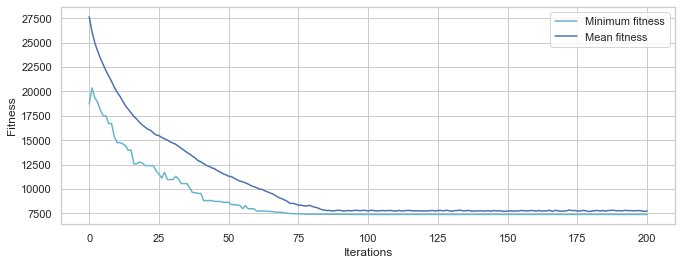

In [15]:
%%time 
NUM_INDIVIDUALS = 2000

MATING_PROB     = 0.8
MUTATING_PROB   = 0.1
NUM_GENERATIONS = 200

best_route_Djibouti, result, log = run_GA_model(NUM_INDIVIDUALS, MATING_PROB, MUTATING_PROB, NUM_GENERATIONS)

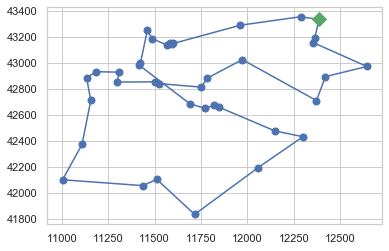

In [16]:
plot_route(create_route(best_route_Djibouti))

# 2. Qatar: 194 cities

## a) Random initialization of all individuals

In [17]:
cities = define_GA_model('qa194.tsp', 0)

c:\users\jlgon\appdata\local\programs\python\python37\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
c:\users\jlgon\appdata\local\programs\python\python37\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


num_individuals 2000
mating_prob 0.8
mutating_prob 0.1
num_generations 200
Fitness of the best individual:  32242.13818299171
Wall time: 6min 4s


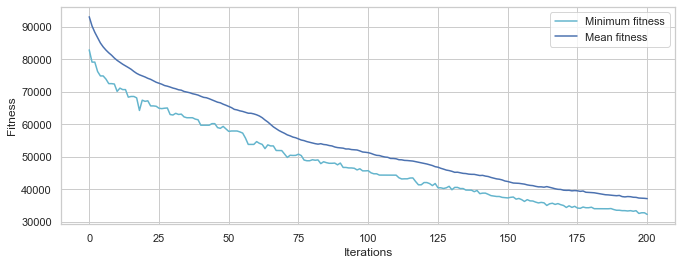

In [18]:
%%time 
NUM_INDIVIDUALS = 2000
MATING_PROB     = 0.8
MUTATING_PROB = 0.1
NUM_GENERATIONS = 200

best_route_Qatar_random, result, log = run_GA_model(NUM_INDIVIDUALS, MATING_PROB, MUTATING_PROB, NUM_GENERATIONS)

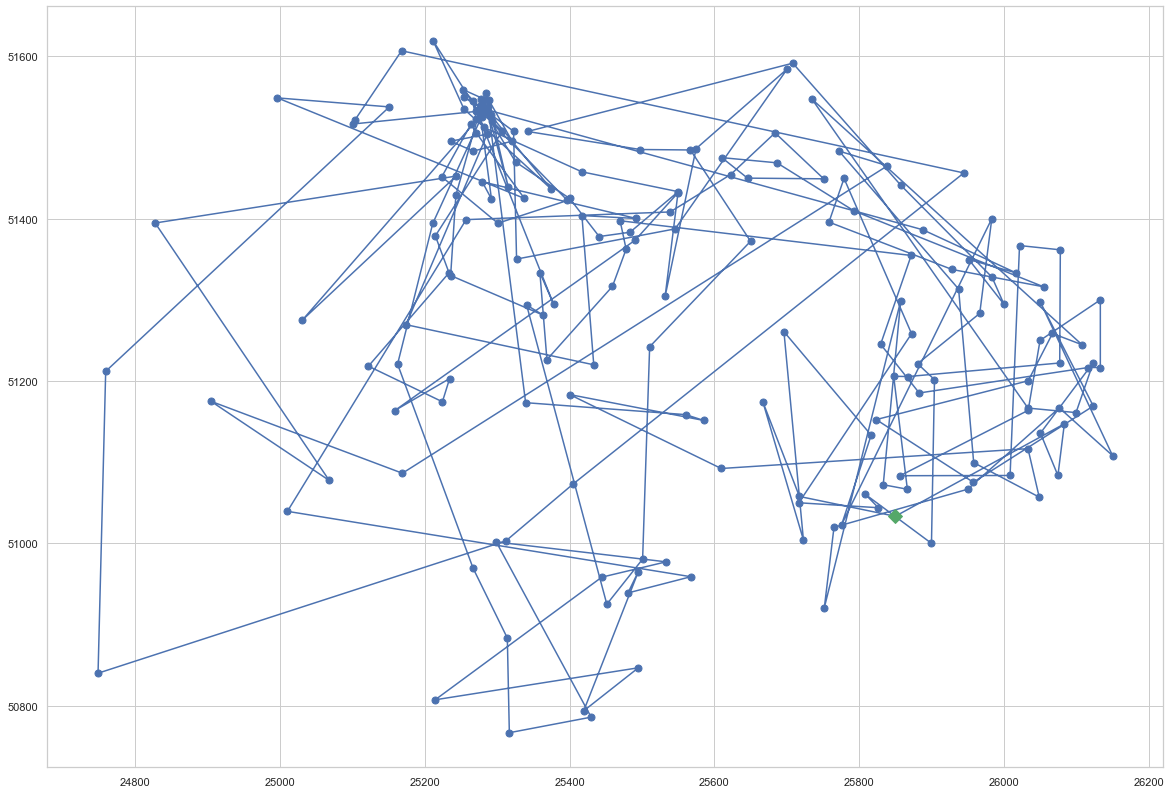

In [19]:
plot_route(create_route(best_route_Qatar_random))

<div class="alert alert-block alert-warning">
    As we can see, the select route is not optimal, with too many comes and goes and length = 32242.13818299171.
</div>

## b) Mixed initialization of individuals
- 80% initialized by the Greedy Search Algorithm
- 20% randomly initialized

In [20]:
# 80% of the population initialized by the Greedy Search Algorithm
cities = define_GA_model('qa194.tsp', 0.8)

c:\users\jlgon\appdata\local\programs\python\python37\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
c:\users\jlgon\appdata\local\programs\python\python37\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


num_individuals 2000
mating_prob 0.8
mutating_prob 0.1
num_generations 200
Fitness of the best individual:  10943.828315816481
Wall time: 4min 53s


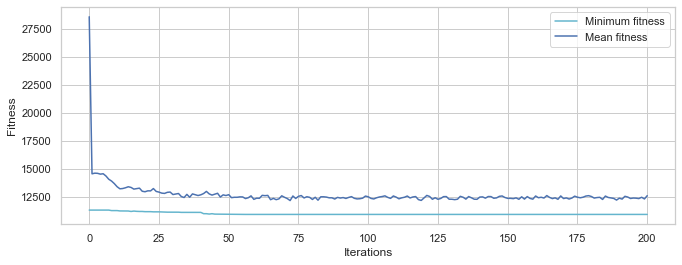

In [21]:
%%time 
NUM_INDIVIDUALS = 2000 
MATING_PROB     = 0.8
MUTATING_PROB = 0.1
NUM_GENERATIONS = 200

best_route_Qatar_mixed, result, log = run_GA_model(NUM_INDIVIDUALS, MATING_PROB, MUTATING_PROB, NUM_GENERATIONS)

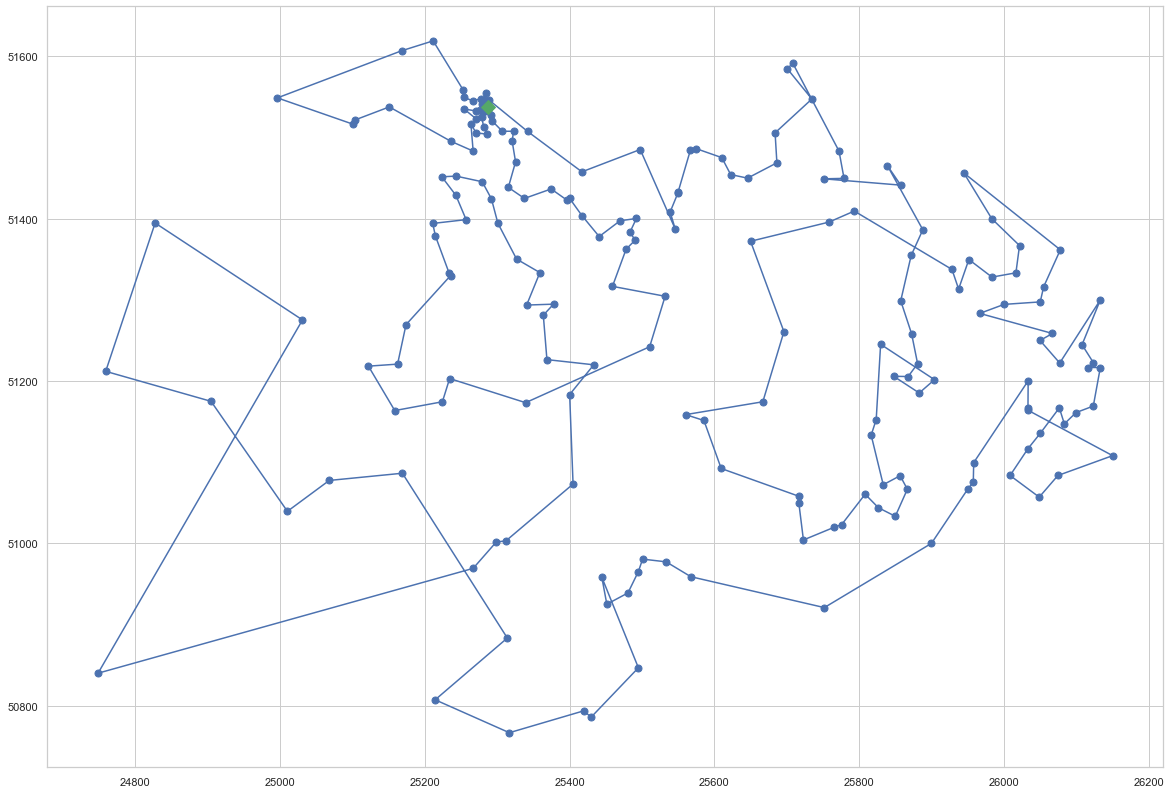

In [22]:
plot_route(create_route(best_route_Qatar_mixed))

<div class="alert alert-block alert-success">
    As we can see, the select route is follows more closely a minimal path, being much shorter: 10943.828315816481.
</div>